# Ranking and Clustering Cities in North Rhine-Westphalia, Germany
-- A Project for Applied Data Science Capstone by IBM/Coursera

Shanshan Wang  
shanshan.wang@uni-due.de  
Feb. 9, 2021

## Table of Contents
<div class="alert alert-block alert-info" style="margin-top: 20px">

<ol>
<li>  <a href="#introduction">Introduction</a></li>
<li>  <a href="#data">Dataset</a></li>
<li><a href="#methodology">Methodologies</a></li>
    3.1  <a href="#frequency">Frequency of categorized venues</a><br>
    3.2  <a href="#kmeans">$k$-means clustering</a><br>
    3.3  <a href="#hierarchical">Hierarchical clustering </a><br>
<li><a href="#results">Results and Discussion</a></li>
    4.1  <a href="#cluster_kmeans">City clusters by k-means clustering</a><br>
    4.2  <a href="#cluster_hierarchical">City clusters by hierarchical clustering</a><br>
    4.3  <a href="#rank">Ranking of cities  </a><br>

<li><a href="#conclusion">Conclusions</a> </li>
<li><a href="#references">References</a> </li>
</ol>
    
</div>

## <a name="introduction"></a>1 Introduction 

A strategic city planning is of benefit to a state government to improve citizens' economic and living levels. To this end, a better understanding to the cities in a state is of importance. In this project we will cluster and  evaluate the cities in North Rhine-Westphalia, Germany based on the fields in working, education, living facilities, transportation, health care and leisure places. By this way, we can find out the top cities in each field as well as the bottom cities that to be improved in the corresponding field. Moreover, we can reveal the correlations among cities based on the above-mentioned fields and figure out how a city's change impacts on the correlated cities. The correlations among cities will facilitate the development of multiple cities synchronously and therefore is useful to be applied to a city planning. 

To simplify the issue, we focus on the frequency of appearance of categorized venues as an index to estimate the level of the development in each city field. By $k$-means clustering and hierarchical clustering, we classify the cities in five clusters. For each cluster, a correlation pattern among different city fields is disclosed. To give a recommendation for traveling or a suggestion for city planning, we rank the five top and bottom cities in each field. 

This project report is organized as follows. In section 2, we describe the dataset we used and the processing for dealing with the raw data. In section 3, we work out the frequency values of venues in each category and classify the cities by the $k$-means clustering and the hierarchical clustering. In section 4, we analyze and discuss the characteristics of city clusters and select out the best and the worst cities in each field. We finally conclude our results in section 5.

## <a name="data"></a>2 Datasets

The project uses two datasets. One is from Wikipedia, where we downloaded a table which lists the ranks of population ranks, names, populations in 2017, areas in square kilometer and populations in per square kilometer of the ten largest cities in North Rhine-Westphalia (NRW). The information of the city names are then used to find their locations. 

The other dataset is from Foursquare company. With a given search query, i.e., a key word, we search the relevant venues around the central locations with a radius of 100000 kilometer. These central locations is set as the locations of the largest ten cities in NRW. In this way, the searched venues almost come from the whole state. The location data from Foursquare company includes the information of location names, categories, addresses, latitudes, longitudes, distances, postal codes, city's names, state's names, countries and so on. We considered multiple search queries, i.e., Company, GmbH, Factory, Fabrik, Office, Restaurant, Supermarket, Shop, University, Universität, College, School, Hospital, Residence, Haus, Park, Transport, and added their information as a column of that table.  


Totally we downloaded 8321 data points for categorized venues from Foursquare company, where the 6144 data points are located in NRW. They are visualized on the maps by categories. We split all search queries into six main categories. They are named as working from the search queries Company, GmbH, Factory, Fabrik and Office, education from University, Universität, College and School, living facilities from Restaurant, Supermarket, Shop, Residence and Haus, health care from Hospital, transportation from Transport, and leisure places from Park. In the following, we will use these 6144 data points for our calculation.


Import necessary Libraries

In [1]:
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from scipy.cluster import hierarchy
import seaborn as sns; sns.set_theme()
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt # plotting library
import requests # library to handle requests

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

! pip install folium==0.12.0 
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


Download the top ten largest cities in North Rhine-Westphalia as central locations

In [2]:
URL = "https://en.wikipedia.org/wiki/North_Rhine-Westphalia"
tables = pd.read_html(URL)
df_topcities=tables[4]
df_topcities

Pos.        Name  Pop. 2017  Area (km²)  Pop. per km2  Map
0     1     Cologne    1080394      405.15          2668  NaN
1     2  Düsseldorf     617280      217.01          2839  NaN
2     3    Dortmund     586600      280.37          2090  NaN
3     4       Essen     583393      210.38          2774  NaN
4     5    Duisburg     498110      232.81          2140  NaN
5     6      Bochum     365529      145.43          2509  NaN
6     7   Wuppertal     353590      168.37          2100  NaN
7     8   Bielefeld     332552      257.83          1285  NaN
8     9        Bonn     325490      141.22          2307  NaN
9    10     Münster     313559      302.91          1034  NaN

Define Foursquare Credentials and Version

In [31]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
ACCESS_TOKEN = '' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 200
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


Define a function for loading data from Foursquare with the central cities with a radius

In [10]:
radius = 100000
def GetData(CLIENT_ID,CLIENT_SECRET,ACCESS_TOKEN,VERSION,LIMIT,df_topcities,search_query,radius):
    for index, city in enumerate(df_topcities['Name']):
        # Define a user_agent and an instance of the geocoder
        address = city+', Germany'
        geolocator = Nominatim(user_agent="foursquare_agent")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        # Define the corresponding URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
        # Send the GET Request and examine the results
        results = requests.get(url).json()
        # assign relevant part of JSON to venues
        venues = results['response']['venues']
        # tranform venues into a dataframe
        dataframe=pd.json_normalize(venues)
        dataframe['search_query']=search_query
        if index==0:
            dataframe_total=dataframe
        else:
            dataframe_total=dataframe_total.append(dataframe, ignore_index=True)
        del address,location,latitude,longitude,url,results,venues 
    return dataframe_total

Search and load the building data based on the given key words

In [11]:
search_query=['Company','GmbH','Factory','Fabrik','Office','Restaurant','Supermarket','Shop','University','Universität','College','School','Hospital','Residence','Haus','Park','Transport']
for i in range(len(search_query)):
    dataframe=GetData(CLIENT_ID,CLIENT_SECRET,ACCESS_TOKEN,VERSION,LIMIT,df_topcities,search_query[i],radius)
    if i==0:
        dataframe_total=dataframe
    else:
        dataframe_total=dataframe_total.append(dataframe, ignore_index=True)
dataframe_total.shape

(8321, 20)

In [12]:
dataframe_total.head()

id                                 name  \
0  5a311f5d029a5526b06f81db     DAHLER & COMPANY Immobilien Köln   
1  4d12234340e6548166d98d1a                         Hair Company   
2  5be061b6491be7002c55bfc1                    aesthetic company   
3  556c82b9498ed18f2480b170  Immobilien Company Petra Emmer e.K.   
4  50ae192ce4b0f706ce71e90f                     Practice Company   

                                          categories    referralId  hasPerk  \
0  [{'id': '5032885091d4c4b30a586d66', 'name': 'R...  v-1612611839    False   
1  [{'id': '4bf58dd8d48988d110951735', 'name': 'S...  v-1612611839    False   
2  [{'id': '54541900498ea6ccd0202697', 'name': 'H...  v-1612611839    False   
3  [{'id': '5032885091d4c4b30a586d66', 'name': 'R...  v-1612611839    False   
4  [{'id': '4bf58dd8d48988d197941735', 'name': 'C...  v-1612611839    False   

     location.address  location.lat  location.lng  \
0    Schildergasse 49     50.936320      6.953768   
1  Herzogstr. 10 - 12     50.937113      6.953708   
2    Neusser Str. 265     50.963793      6.953513   
3    Dürener Str. 149     50.931332      6.917490   
4                 NaN     50.938027      6.945670   

                             location.labeledLatLngs  location.distance  \
0  [{'label': 'display', 'lat': 50.9363195, 'lng'...                491   
1  [{'label': 'display', 'lat': 50.937113, 'lng':...                460   
2  [{'label': 'display', 'lat': 50.963793, 'lng':...               2867   
3  [{'label': 'display', 'lat': 50.9313324, 'lng'...               3081   
4  [{'label': 'display', 'lat': 50.93802689569254...               1004   

  location.postalCode location.cc location.city       location.state  \
0               50667          DE          Köln  Nordrhein-Westfalen   
1               50667          DE          Köln  Nordrhein-Westfalen   
2               50733          DE          Köln  Nordrhein-Westfalen   
3               50931          DE          Köln  Nordrhein-Westfalen   
4                 NaN          DE          Köln  Nordrhein-Westfalen   

  location.country                      location.formattedAddress  \
0      Deutschland    [Schildergasse 49, 50667 Köln, Deutschland]   
1      Deutschland  [Herzogstr. 10 - 12, 50667 Köln, Deutschland]   
2      Deutschland    [Neusser Str. 265, 50733 Köln, Deutschland]   
3      Deutschland    [Dürener Str. 149, 50931 Köln, Deutschland]   
4      Deutschland                            [Köln, Deutschland]   

  venuePage.id location.crossStreet location.neighborhood search_query  
0          NaN                  NaN                   NaN      Company  
1          NaN                  NaN                   NaN      Company  
2          NaN                  NaN                   NaN      Company  
3    150522531                  NaN                   NaN      Company  
4          NaN                  NaN                   NaN      Company

Define information of interest and filter dataframe

In [13]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories','search_query'] + [col for col in dataframe_total.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe_total.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head()

name                       categories  \
0     DAHLER & COMPANY Immobilien Köln               Real Estate Office   
1                         Hair Company               Salon / Barbershop   
2                    aesthetic company          Health & Beauty Service   
3  Immobilien Company Petra Emmer e.K.               Real Estate Office   
4                     Practice Company  College Administrative Building   

  search_query             address        lat       lng  \
0      Company    Schildergasse 49  50.936320  6.953768   
1      Company  Herzogstr. 10 - 12  50.937113  6.953708   
2      Company    Neusser Str. 265  50.963793  6.953513   
3      Company    Dürener Str. 149  50.931332  6.917490   
4      Company                 NaN  50.938027  6.945670   

                                      labeledLatLngs  distance postalCode  cc  \
0  [{'label': 'display', 'lat': 50.9363195, 'lng'...       491      50667  DE   
1  [{'label': 'display', 'lat': 50.937113, 'lng':...       460      50667  DE   
2  [{'label': 'display', 'lat': 50.963793, 'lng':...      2867      50733  DE   
3  [{'label': 'display', 'lat': 50.9313324, 'lng'...      3081      50931  DE   
4  [{'label': 'display', 'lat': 50.93802689569254...      1004        NaN  DE   

   city                state      country  \
0  Köln  Nordrhein-Westfalen  Deutschland   
1  Köln  Nordrhein-Westfalen  Deutschland   
2  Köln  Nordrhein-Westfalen  Deutschland   
3  Köln  Nordrhein-Westfalen  Deutschland   
4  Köln  Nordrhein-Westfalen  Deutschland   

                                formattedAddress crossStreet neighborhood  \
0    [Schildergasse 49, 50667 Köln, Deutschland]         NaN          NaN   
1  [Herzogstr. 10 - 12, 50667 Köln, Deutschland]         NaN          NaN   
2    [Neusser Str. 265, 50733 Köln, Deutschland]         NaN          NaN   
3    [Dürener Str. 149, 50931 Köln, Deutschland]         NaN          NaN   
4                            [Köln, Deutschland]         NaN          NaN   

                         id  
0  5a311f5d029a5526b06f81db  
1  4d12234340e6548166d98d1a  
2  5be061b6491be7002c55bfc1  
3  556c82b9498ed18f2480b170  
4  50ae192ce4b0f706ce71e90f

In [14]:
dataframe_filtered.shape

(8321, 17)

Select the rows with the locations in state Nordrhein-Westfalen

In [15]:
df=dataframe_filtered[dataframe_filtered['state']=='Nordrhein-Westfalen'];
#removes duplicate rows based on lantitude and longitude.
df.drop_duplicates(subset=['lat', 'lng', 'city', 'search_query'], keep='last')
df.reset_index(drop=True,inplace=True)
df.shape

(6144, 17)

Create map of Nordrhein-Westfalen (NRW) using latitude and longitude values and add markers to map

In [23]:
address = 'Nordrhein-Westfalen, Germany'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_NRW = folium.Map(location=[latitude, longitude], zoom_start=8)
map_NRW1 = folium.Map(location=[latitude, longitude], zoom_start=8)
map_NRW2 = folium.Map(location=[latitude, longitude], zoom_start=8)
map_NRW3 = folium.Map(location=[latitude, longitude], zoom_start=8)
map_NRW4 = folium.Map(location=[latitude, longitude], zoom_start=8)
map_NRW5 = folium.Map(location=[latitude, longitude], zoom_start=8)
map_NRW6 = folium.Map(location=[latitude, longitude], zoom_start=8)

for lat, lng, name, categories, city, sq in zip(df['lat'], df['lng'], df['name'], df['categories'], df['city'],df['search_query']):
    label = '{}, {}, {}'.format(name, categories, city)
    label = folium.Popup(label, parse_html=True)
    if sq in ('Company','GmbH','Factory','Fabrik','Office'):
        color_query='orange'
        folium.CircleMarker([lat, lng],radius=5,popup=label,color='black',fill=True,fill_color=color_query,fill_opacity=0.7,
        parse_html=False).add_to(map_NRW1)  
    elif sq in ('Restaurant','Supermarket','Shop','Residence','Haus'):
        color_query='red'
        folium.CircleMarker([lat, lng],radius=5,popup=label,color='black',fill=True,fill_color=color_query,fill_opacity=0.7,
        parse_html=False).add_to(map_NRW2) 
    elif sq in ('University','College','School','Universität'):
        color_query='blue'
        folium.CircleMarker([lat, lng],radius=5,popup=label,color='black',fill=True,fill_color=color_query,fill_opacity=0.7,
        parse_html=False).add_to(map_NRW3) 
    elif sq in ('Hospital'):
        color_query='white' 
        folium.CircleMarker([lat, lng],radius=5,popup=label,color='black',fill=True,fill_color=color_query,fill_opacity=0.7,
        parse_html=False).add_to(map_NRW4) 
    elif sq in ('Transport'):
        color_query='purple' 
        folium.CircleMarker([lat, lng],radius=5,popup=label,color='black',fill=True,fill_color=color_query,fill_opacity=0.7,
        parse_html=False).add_to(map_NRW5) 
    elif sq in ('Park'):
        color_query='green'
        folium.CircleMarker([lat, lng],radius=5,popup=label,color='black',fill=True,fill_color=color_query,fill_opacity=0.7,
        parse_html=False).add_to(map_NRW6) 
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='black',
        fill=True,
        fill_color=color_query, #'#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NRW)  

#### Company(GmbH), Factory (Fabrik), Office

In [21]:
map_NRW1

#### Restaurant, Supermarket, Shop, Residence, Haus

In [25]:
map_NRW2

#### University (Universität), College, School

In [30]:
map_NRW3

#### Hospital

In [27]:
map_NRW4

#### Transportation

In [135]:
map_NRW5

#### Park

In [32]:
map_NRW6

## <a name="methodology"></a>3 Methodologies 

### <a name="frequency"></a>3.1 Frequency of categorized venues 

Calculate the number of venues of each field in each city

In [137]:
df_sq=df['search_query'].str.get_dummies(sep=',')
df_sq['city']=df['city']
df_uni=df_sq[['University', 'Universität']].sum(axis=1)
df_res=df_sq[['Residence', 'Haus']].sum(axis=1)
df_com=df_sq[['Company', 'GmbH']].sum(axis=1)
df_fac=df_sq[['Factory', 'Fabrik']].sum(axis=1)
df_sq.drop(['University', 'Universität','Residence', 'Haus','Company', 'GmbH','Factory', 'Fabrik'], axis=1, inplace=True)
df_sq['University']=df_uni
df_sq['Residence']=df_res
df_sq['Company']=df_com
df_sq['Factory']=df_fac
df_city=df_sq.groupby(['city']).sum()
# correlct the data for Wuppertal and drop the row for the wrong city name Wupperthal
df_city.loc['Wuppertal',:]=df_city.loc['Wuppertal',:]+df_city.loc['Wupperthal',:]
df_city.drop(index='Wupperthal',inplace=True)
df_city

College  Hospital  Office  Park  Restaurant  School  Shop  \
city                                                                   
Aachen           0         0       0     1           0       1     0   
Ahlen            0         3       0     0           3       0     0   
Alfter           0         0       1     0           0       0     0   
Alpen            0         0       0     1           0       0     0   
Arnsberg         0         6       0     0           1       0     0   
...            ...       ...     ...   ...         ...     ...   ...   
Willich          0         5       0     0           0       0     0   
Windeck          0         0       0     0           0       4     0   
Witten           0         3       0     6           0       5     2   
Wuppertal        9         0      13    14           2       0    13   
Wülfrath         0         0       0     0           2       0     0   

           Supermarket  Transport  University  Residence  Company  Factory  
city                                                                        
Aachen               6          4          42          5        0        4  
Ahlen                0          0           0          0        0        0  
Alfter               0          0           0          0        0        0  
Alpen                0          0           0          0        0        0  
Arnsberg             0          0           0          3        0        0  
...                ...        ...         ...        ...      ...      ...  
Willich              0          2           0          0        0        4  
Windeck              0          0           0          0        0        0  
Witten               0          0           2          6        0        0  
Wuppertal            0          6          11         10       71       21  
Wülfrath             0          0           0          0        0        9  

[211 rows x 13 columns]

Convert the number of venues to the appearance frequency 

In [34]:
total_query=df_sq.sum()
for i in range(len(total_query)):
    df_city.iloc[:,i]=df_city.iloc[:,i]/total_query[i]
df_city

College  Hospital    Office      Park  Restaurant    School  \
city                                                                     
Aachen       0.000  0.000000  0.000000  0.002217    0.000000  0.002681   
Ahlen        0.000  0.007444  0.000000  0.000000    0.006682  0.000000   
Alfter       0.000  0.000000  0.002591  0.000000    0.000000  0.000000   
Alpen        0.000  0.000000  0.000000  0.002217    0.000000  0.000000   
Arnsberg     0.000  0.014888  0.000000  0.000000    0.002227  0.000000   
...            ...       ...       ...       ...         ...       ...   
Willich      0.000  0.012407  0.000000  0.000000    0.000000  0.000000   
Windeck      0.000  0.000000  0.000000  0.000000    0.000000  0.010724   
Witten       0.000  0.007444  0.000000  0.013304    0.000000  0.013405   
Wuppertal    0.072  0.000000  0.033679  0.031042    0.004454  0.000000   
Wülfrath     0.000  0.000000  0.000000  0.000000    0.004454  0.000000   

               Shop  Supermarket  Transport  University  Residence   Company  \
city                                                                           
Aachen     0.000000     0.026432   0.011019    0.063927   0.008210  0.000000   
Ahlen      0.000000     0.000000   0.000000    0.000000   0.000000  0.000000   
Alfter     0.000000     0.000000   0.000000    0.000000   0.000000  0.000000   
Alpen      0.000000     0.000000   0.000000    0.000000   0.000000  0.000000   
Arnsberg   0.000000     0.000000   0.000000    0.000000   0.004926  0.000000   
...             ...          ...        ...         ...        ...       ...   
Willich    0.000000     0.000000   0.005510    0.000000   0.000000  0.000000   
Windeck    0.000000     0.000000   0.000000    0.000000   0.000000  0.000000   
Witten     0.004149     0.000000   0.000000    0.003044   0.009852  0.000000   
Wuppertal  0.026971     0.000000   0.016529    0.016743   0.016420  0.080499   
Wülfrath   0.000000     0.000000   0.000000    0.000000   0.000000  0.000000   

            Factory  
city                 
Aachen     0.005427  
Ahlen      0.000000  
Alfter     0.000000  
Alpen      0.000000  
Arnsberg   0.000000  
...             ...  
Willich    0.005427  
Windeck    0.000000  
Witten     0.000000  
Wuppertal  0.028494  
Wülfrath   0.012212  

[211 rows x 13 columns]

Combine the sub-categories into one main category

In [136]:
df_city2=pd.DataFrame(df_city[['Company','Factory','Office']].sum(axis=1),columns=['working'])
df_city2['education']=pd.DataFrame(df_city[['College','University','School']].sum(axis=1))
df_city2['living facilities']=pd.DataFrame(df_city[['Restaurant','Supermarket','Shop','Residence']].sum(axis=1))
df_city2['health care']=pd.DataFrame(df_city[['Hospital']].sum(axis=1))
df_city2['transportation']=pd.DataFrame(df_city[['Transport']].sum(axis=1))
df_city2['leisure places']=pd.DataFrame(df_city[['Park']].sum(axis=1))
df_city2

working  education  living facilities  health care  \
city                                                             
Aachen     0.005427   0.066608           0.034642     0.000000   
Ahlen      0.000000   0.000000           0.006682     0.007444   
Alfter     0.002591   0.000000           0.000000     0.000000   
Alpen      0.000000   0.000000           0.000000     0.000000   
Arnsberg   0.000000   0.000000           0.007153     0.014888   
...             ...        ...                ...          ...   
Willich    0.005427   0.000000           0.000000     0.012407   
Windeck    0.000000   0.010724           0.000000     0.000000   
Witten     0.000000   0.016449           0.014002     0.007444   
Wuppertal  0.142672   0.088743           0.047846     0.000000   
Wülfrath   0.012212   0.000000           0.004454     0.000000   

           transportation  leisure places  
city                                       
Aachen           0.011019        0.002217  
Ahlen            0.000000        0.000000  
Alfter           0.000000        0.000000  
Alpen            0.000000        0.002217  
Arnsberg         0.000000        0.000000  
...                   ...             ...  
Willich          0.005510        0.000000  
Windeck          0.000000        0.000000  
Witten           0.000000        0.013304  
Wuppertal        0.016529        0.031042  
Wülfrath         0.000000        0.000000  

[211 rows x 6 columns]

### <a name="kmeans"></a>3.2 $k$-means clustering 

We will use df_city2 as our data matrix to cluster cities into 5 groups in NRW.

In [138]:
# set number of clusters
kclusters = 6
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_city2)
# check cluster labels generated for each row in the dataframe
cluster=kmeans.labels_ 
cluster

array([4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 3, 5, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0,
       0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0], dtype=int32)

In [139]:
# add the clustering labels as one column of data matrix df_city3
df_city_km=df_city2.copy()
df_city_km['cluster']=cluster
# reorder the cluster number by the value of each city averaged over all aspects
mv=list(df_city_km.groupby(['cluster']).mean().mean(axis=1))
idx=sorted(range(len(mv)), key=lambda k: mv[k], reverse=True)
for i in range(len(idx)):
    cluster[cluster==idx[i]]=10+i
clu=cluster-9
clu

array([5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 3, 4, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 3, 6, 6, 6, 1,
       6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 1, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 4, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6,
       6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6], dtype=int32)

Update the cluster labels in the data matrix df_city_km

In [140]:
df_city_km.drop(columns=['cluster'])
df_city_km['cluster']=clu

Visualize the clusters in a map

In [141]:
map_city = folium.Map(location=[latitude, longitude], zoom_start=8)
for city, cluster in zip(df_city_km.index, clu):
    add = city+', Nordrhein-Westfalen, Germany'
    loc = geolocator.geocode(add)
    lat = loc.latitude
    lng = loc.longitude
    label = 'cluster {}, {}'.format(cluster, city)
    label = folium.Popup(label, parse_html=True)
    if cluster==1:
        color_cluster='red'
    elif cluster==2:
        color_cluster='yellow'
    elif cluster==3:
        color_cluster='cyan'
    elif cluster==4:
        color_cluster='white' 
    elif cluster==5:
        color_cluster='darkviolet'
    elif cluster==6:
        color_cluster='blue'
    r=int(12-cluster)
    folium.CircleMarker(
        [lat, lng],
        radius=r,
        popup=label,
        color='black',
        fill=True,
        fill_color=color_cluster, #'#3186cc',
        fill_opacity=0.9,
        parse_html=False).add_to(map_city) 
map_city

### <a name="hierarchical"></a>3.3  Hierarchical clustering 

Calculate the correlation matrix of cities with the data matrix df_city

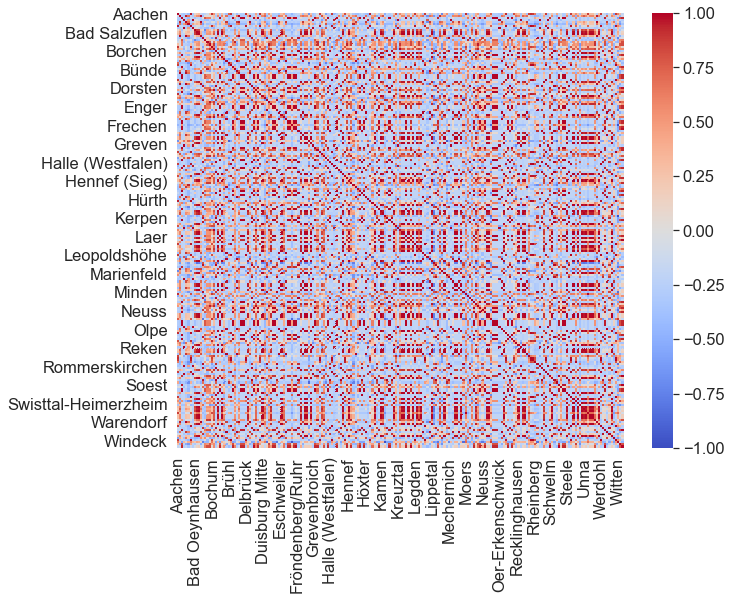

In [142]:
ax = plt.subplots(figsize=(10, 8))
ax=sns.heatmap(df_city2.T.corr(),cmap="coolwarm", vmin=-1, vmax=1).set(ylabel='',xlabel='')

Classify cities with hierarchical clustering. The strongly correlated city groups are shown in the diagonal blocks in the clustermap.

/Users/working/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(860.8, 0.5, '')

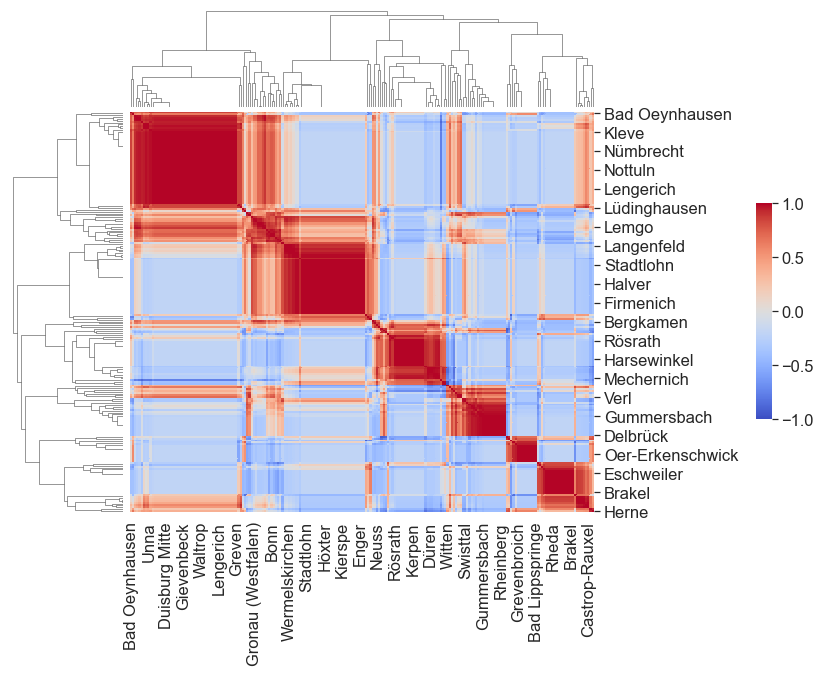

In [177]:
g = sns.clustermap(df_city2.T.corr(),figsize=(11, 10), cmap="coolwarm", vmin=-1, vmax=1, cbar_pos=(0.97, .4, .02, .3))
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')

Get the first k cluster labels

In [144]:
# get order of indices from clustermap
index_col=g.dendrogram_col.reordered_ind
df_city_reorder=df_city.iloc[index_col,:]
# get the linkage from clustermap
link_row=g.dendrogram_row.linkage
# use the linkage matrix to get the first k cluster labels. 
# Here we set k=6 to obtain the first five clusters
fl = hierarchy.fcluster(link_row,6,criterion='maxclust')
fl

array([4, 6, 2, 5, 6, 6, 4, 5, 1, 1, 1, 6, 3, 2, 3, 1, 4, 1, 3, 1, 2, 1,
       1, 6, 3, 4, 2, 3, 6, 6, 2, 2, 4, 1, 6, 3, 2, 1, 2, 4, 1, 4, 3, 1,
       1, 2, 2, 3, 6, 1, 1, 6, 2, 2, 3, 2, 2, 3, 1, 6, 1, 1, 5, 1, 5, 2,
       1, 4, 1, 1, 5, 2, 3, 4, 5, 2, 6, 3, 1, 4, 1, 1, 1, 6, 6, 1, 2, 3,
       2, 6, 5, 4, 2, 1, 3, 2, 1, 1, 3, 3, 2, 3, 1, 1, 5, 1, 1, 1, 2, 1,
       2, 1, 4, 1, 1, 1, 6, 4, 5, 6, 1, 3, 3, 2, 1, 6, 1, 3, 3, 5, 6, 1,
       1, 6, 1, 3, 4, 2, 3, 1, 2, 1, 1, 2, 3, 2, 1, 1, 4, 2, 2, 2, 5, 6,
       1, 4, 2, 3, 2, 4, 6, 1, 5, 1, 1, 6, 1, 4, 4, 4, 3, 5, 3, 1, 4, 5,
       2, 1, 3, 3, 2, 3, 2, 2, 1, 3, 4, 1, 4, 1, 3, 1, 1, 1, 4, 1, 1, 1,
       6, 1, 4, 3, 2, 6, 3, 1, 6, 4, 4, 2, 2], dtype=int32)

Reorder the city index in data matrix df_city2 based on the cluster labels and reconstruct the heatmap with clusters. The indices of cities in each cluster are not reordered. Thus the following heatmap is a little different from the above clustermap.

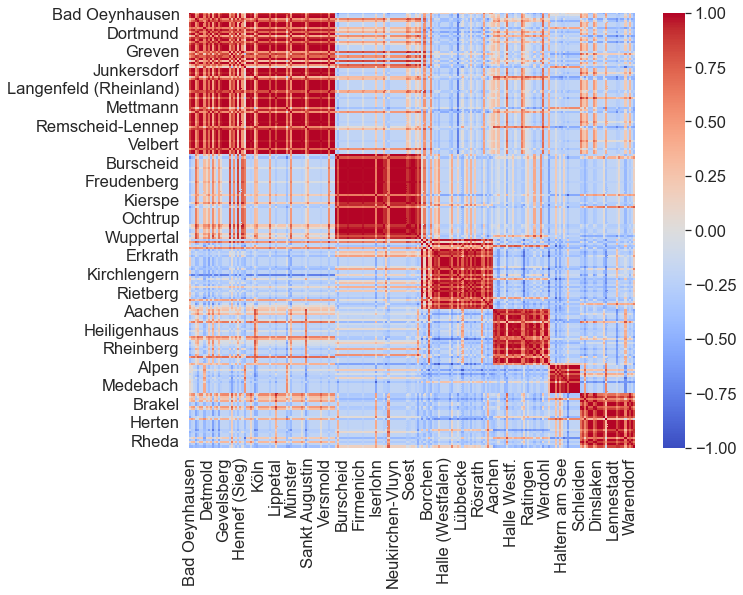

In [175]:
df_reorder=df_city2.reset_index()
for i in range(6):
    a=np.where(fl==i+1) 
    if i==0:
        df_city_hi=df_reorder.iloc[a[0],:]
    else:
        df_city_hi=df_city_hi.append(df_reorder.iloc[a[0],:], ignore_index=True)

df_city_hi.set_index('city',inplace=True)
fig = plt.figure(figsize=(10, 8))
ax=sns.heatmap(df_city_hi.T.corr(),cmap="coolwarm", vmin=-1, vmax=1).set(ylabel='',xlabel='')

Visualize the city clusters in a map

In [146]:
map_city2 = folium.Map(location=[latitude, longitude], zoom_start=8)
for city, cluster in zip(df_city2.index, fl):
    add = city+', Nordrhein-Westfalen, Germany'
    loc = geolocator.geocode(add)
    lat = loc.latitude
    lng = loc.longitude
    label = 'cluster {}, {}'.format(cluster, city)
    label = folium.Popup(label, parse_html=True)
    if cluster==1:
        color_cluster='red'
    elif cluster==2:
        color_cluster='yellow'
    elif cluster==3:
        color_cluster='cyan'
    elif cluster==4:
        color_cluster='white' 
    elif cluster==5:
        color_cluster='darkviolet'
    elif cluster==6:
        color_cluster='blue'
    r=int(12-cluster)
    folium.CircleMarker(
        [lat, lng],
        radius=r,
        popup=label,
        color='black',
        fill=True,
        fill_color=color_cluster, #'#3186cc',
        fill_opacity=0.9,
        parse_html=False).add_to(map_city2) 
map_city2

## <a name="results"></a>4 Results and Disscusion 

### <a name="cluster_kmeans"></a>4.1 City clusters by k-means clustering 

average the frequencies over all cities in each cluster

In [147]:
df_city_km.groupby(['cluster']).mean()

working  education  living facilities  health care  transportation  \
cluster                                                                        
1        0.458047   0.394383           0.535867     0.060794        0.108815   
2        0.279791   0.199539           0.375093     0.038462        0.039945   
3        0.124520   0.338681           0.166767     0.074442        0.049587   
4        0.110777   0.072544           0.130109     0.014888        0.014325   
5        0.022348   0.049633           0.051068     0.022687        0.004329   
6        0.002803   0.002200           0.004113     0.002134        0.002598   

         leisure places  
cluster                  
1              0.138581  
2              0.057650  
3              0.037694  
4              0.022616  
5              0.029458  
6              0.001022

For each cluster, get the city names and the score, i.e., the average frequency over different fields

In [148]:
mv=df_city_km.groupby(['cluster']).mean().mean(axis=1)
c1=df_city_km[df_city_km['cluster']==1].index.str.cat(sep=',')
c2=df_city_km[df_city_km['cluster']==2].index.str.cat(sep=',')
c3=df_city_km[df_city_km['cluster']==3].index.str.cat(sep=',')
c4=df_city_km[df_city_km['cluster']==4].index.str.cat(sep=',')
c5=df_city_km[df_city_km['cluster']==5].index.str.cat(sep=',')
c6=df_city_km[df_city_km['cluster']==6].index.str.cat(sep=',')
cluster_city=pd.DataFrame(data={'score':mv,'city':[c1,c2, c3,c4,c5,c6]},columns=['score','city'])
pd.set_option('display.max_colwidth', 120)
cluster_city

score  \
cluster             
1        0.282748   
2        0.165080   
3        0.131948   
4        0.060877   
5        0.029921   
6        0.002479   

                                                                                                                            city  
cluster                                                                                                                           
1                                                                                                                Düsseldorf,Köln  
2                                                                                                                 Dortmund,Essen  
3                                                                                                                Bochum,Duisburg  
4                                                                                 Bielefeld,Bonn,Gelsenkirchen,Münster,Wuppertal  
5                                                                 Aachen,Hagen,Herne,Krefeld,Mülheim (Ruhr),Oberhausen,Paderborn  
6        Ahlen,Alfter,Alpen,Arnsberg,Bad Driburg,Bad Honnef,Bad Lippspringe,Bad Oeynhausen,Bad Salzuflen,Bad Sassendorf,Becku...

Box plots of each cluster in each city field 

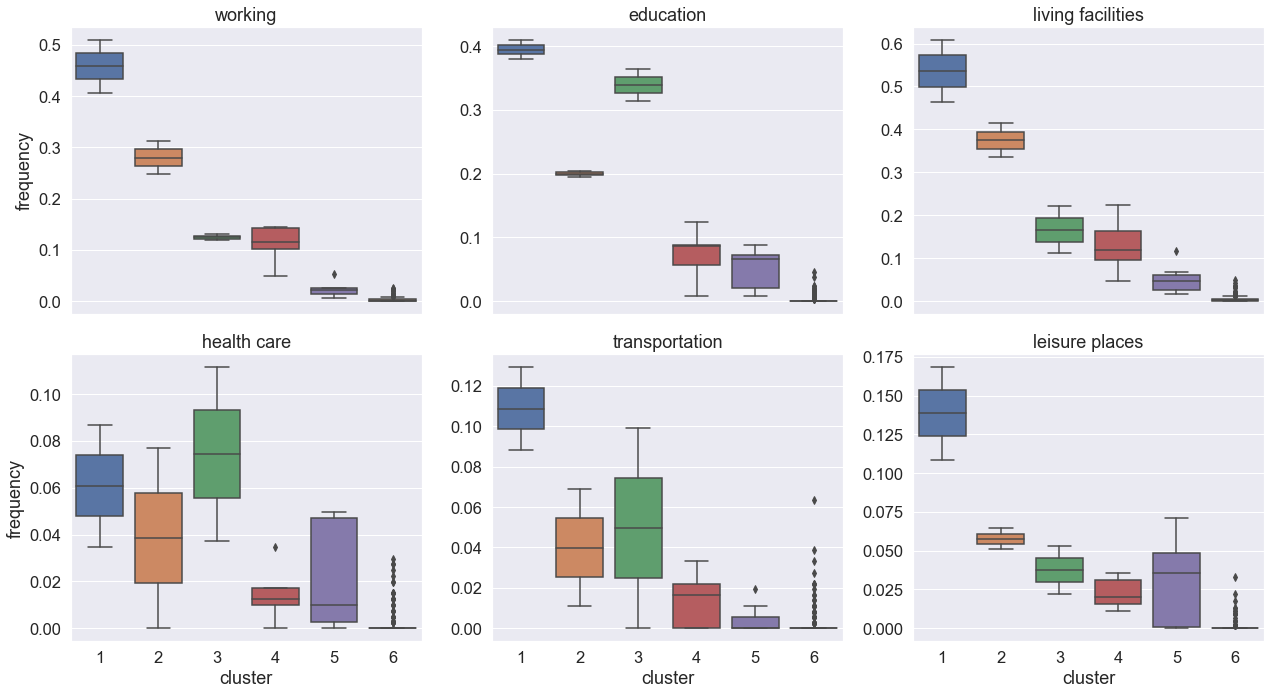

In [149]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=False, figsize=(20,10))
sns.boxplot(ax=axes[0, 0], data=df_city_km, x='cluster', y='working').set(title='working', ylabel='frequency',xlabel='')
sns.boxplot(ax=axes[0, 1], data=df_city_km, x='cluster', y='education').set(title='education',ylabel='',xlabel='')
sns.boxplot(ax=axes[0, 2], data=df_city_km, x='cluster', y='living facilities').set(title='living facilities', ylabel='',xlabel='')
sns.boxplot(ax=axes[1, 0], data=df_city_km, x='cluster', y='health care').set(title='health care', ylabel='frequency')
sns.boxplot(ax=axes[1, 1], data=df_city_km, x='cluster', y='transportation').set(title='transportation',ylabel='')
sns.boxplot(ax=axes[1, 2], data=df_city_km, x='cluster', y='leisure places').set(title='leisure places',ylabel='')
sns.set(font_scale=1.5)
fig.tight_layout(rect=[0, 0, .9, 1])
plt.show()

Cluster 1 includes the state's capital D\"usseldorf and the state's largest city K\"oln. This cluster exhibits higher levels in the fields of working, education, living facilities, health care, transportation and leisure places. In contrast, cluster 6 which contains many small cities has the lowest level in each city field. Besides the ones in cluster 1, the cities in cluster 2, i.e., Dortmund and Essen, are suitable for working, living and relaxing, while the cities in cluster 3, i.e., Bochum and Duisburg, have more facilities in education, health care and transportation. 



Correlation matrices of city fields for each cluster

<ipython-input-150-6aea18d8d877>:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


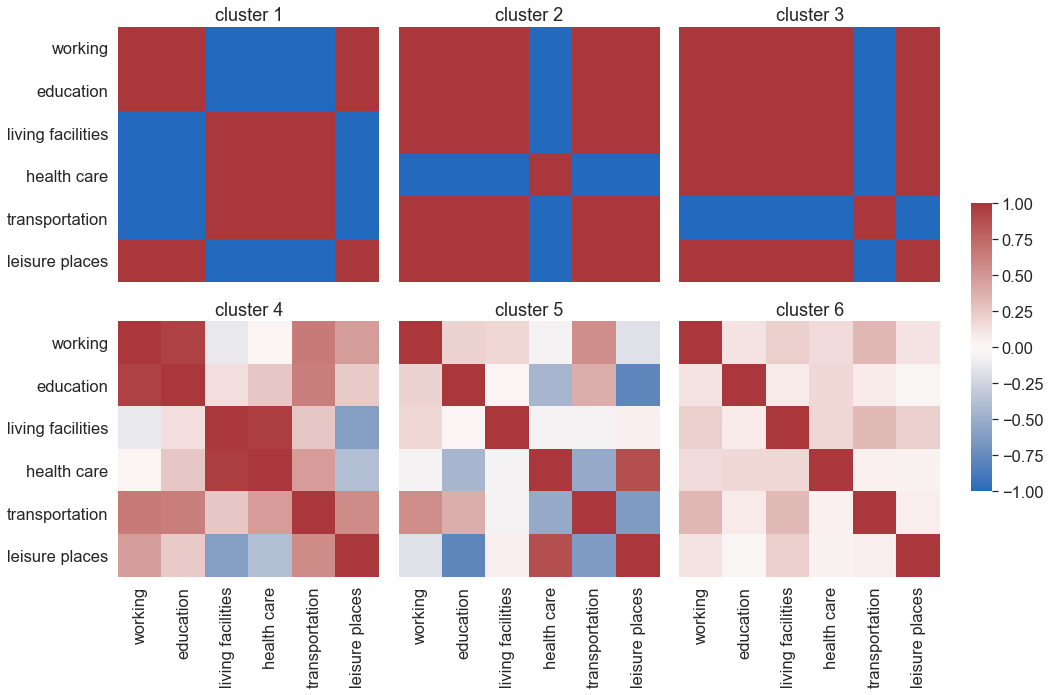

In [150]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,10))
cbar_ax = fig.add_axes([.91,.3,.02,.4])
sns.heatmap(df_city_km[df_city_km['cluster']==1].iloc[:,0:6].corr(),cmap="vlag",cbar_ax = cbar_ax, vmin=-1, vmax=1,ax=axes[0,0]).set(title='cluster 1')
sns.heatmap(df_city_km[df_city_km['cluster']==2].iloc[:,0:6].corr(),cmap="vlag",cbar_ax = cbar_ax, vmin=-1, vmax=1,ax=axes[0,1]).set(title='cluster 2')
sns.heatmap(df_city_km[df_city_km['cluster']==3].iloc[:,0:6].corr(),cmap="vlag",cbar_ax = cbar_ax, vmin=-1, vmax=1,ax=axes[0,2]).set(title='cluster 3')
sns.heatmap(df_city_km[df_city_km['cluster']==4].iloc[:,0:6].corr(),cmap="vlag",cbar_ax = cbar_ax, vmin=-1, vmax=1,ax=axes[1,0]).set(title='cluster 4')
sns.heatmap(df_city_km[df_city_km['cluster']==5].iloc[:,0:6].corr(),cmap="vlag",cbar_ax = cbar_ax, vmin=-1, vmax=1,ax=axes[1,1]).set(title='cluster 5')
sns.heatmap(df_city_km[df_city_km['cluster']==6].iloc[:,0:6].corr(),cmap="vlag",cbar_ax = cbar_ax, vmin=-1, vmax=1,ax=axes[1,2]).set(title='cluster 6')
sns.set(font_scale=1.5)
fig.tight_layout(rect=[0, 0, .9, 1])
plt.show()

The correlation matrices among six categories show different patterns. For cluster 1, D\"usseldorf and K\"oln exihibit the strong correlations among working, education and leisure places, and among living facilities, health care and transportation, respectively. Clusters 2 and 3 show the strong correlations among all fields except for the health care in cluster 2 and the transportation in cluster 3. Although the obviously strong correlation between working and education and between living facilities and health care can be found in cluster 4, the strength of correlation matrices in the last three clusters are weaker than those in the first three clusters, as more cities included in the last clusters reduce the correlation values. These strong positive correlations shown in the matrices imply that an improvement (or a deterioration) in one city field will also advance (or drop) the level of another field. The strong negative correlations, however, reveal an opposite relation between two city fields. 


### <a name="cluster_hierarchical"></a>4.2 City clusters by hierarchical clustering 

For each cluster, get the city names and the score, i.e., the average frequency over different fields

In [157]:
df_city_hi['cluster']=fl
mv_hi=df_city_hi.groupby(['cluster']).mean().mean(axis=1)
c1_hi=df_city_hi[df_city_hi['cluster']==1].index.str.cat(sep=',')
c2_hi=df_city_hi[df_city_hi['cluster']==2].index.str.cat(sep=',')
c3_hi=df_city_hi[df_city_hi['cluster']==3].index.str.cat(sep=',')
c4_hi=df_city_hi[df_city_hi['cluster']==4].index.str.cat(sep=',')
c5_hi=df_city_hi[df_city_hi['cluster']==5].index.str.cat(sep=',')
c6_hi=df_city_hi[df_city_hi['cluster']==6].index.str.cat(sep=',')
cluster_city_hi=pd.DataFrame(data={'score':mv_hi,'city':[c1_hi,c2_hi, c3_hi,c4_hi,c5_hi,c6_hi]},columns=['score','city'])
pd.set_option('display.max_colwidth', 140)
cluster_city_hi

score  \
cluster             
1        0.007370   
2        0.009091   
3        0.008389   
4        0.013200   
5        0.008170   
6        0.019786   

                                                                                                                                                city  
cluster                                                                                                                                               
1        Detmold,Dortmund,Duisburg Mitte,Gelsenkirchen,Gievenbeck,Gronau (Westfalen),Haan,Hattingen,Königswinter,Leichlingen,Lippetal,Menden (Sau...  
2        Bad Sassendorf,Espelkamp,Gütersloh,Hilden,Kleve,Krefeld,Langenfeld (Rheinland),Lemgo,Mettmann,Mönchengladbach,Rees,Remscheid,Rheda-Wiede...  
3        Emsdetten,Essen,Greven,Hennef (Sieg),Junkersdorf,Lage,Marienfeld,Mülheim (Ruhr),Remscheid-Lennep,Schwerte,Burscheid,Enger,Höxter,Monheim...  
4        Bad Oeynhausen,Bornheim-Walberberg,Gevelsberg,Herford,Köln,Lengerich,Lüdinghausen,Warstein,Coesfeld,Extertal,Laer,Borchen,Erkrath,Rösrat...  
5                            Bielefeld,Bottrop,Unna,Versmold,Bergisch Gladbach,Datteln,Kierspe,Soest,Frechen,Marl,Halle Westf.,Rheinberg,Alpen,Hagen  
6        Bad Salzuflen,Bonn,Borgholzhausen,Düsseldorf,Hennef,Kamen,Kamp-Lintfort,Kürten,Münster,Overath,Stolberg,Drensteinfurt,Gronau,Halle,Kalle...

Different from $k$-means clustering based on the data matrix, the hierarchical clustering groups the cities with respect to their correlation matrix. Therefore, the cities with strong correlations are grouped into the same cluster, which is different from those by $k$-means clustering. 

Box plots of each cluster in each city field 

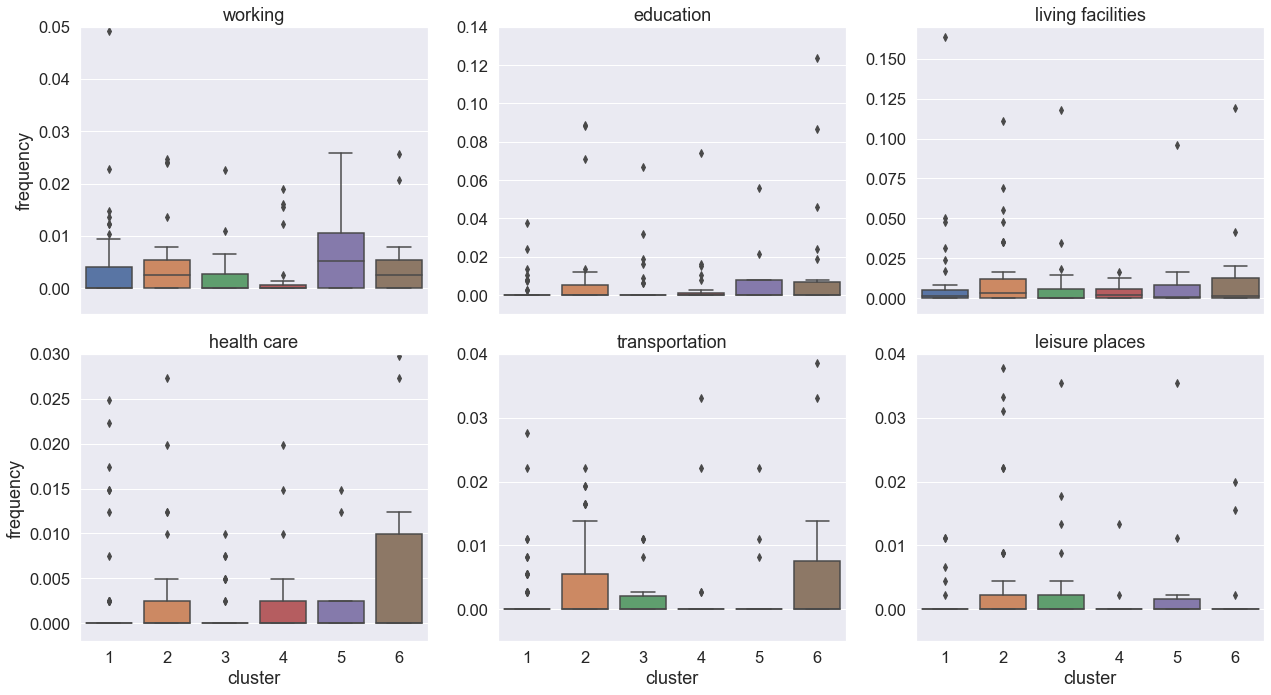

In [172]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=False, figsize=(20,10))
sns.boxplot(ax=axes[0, 0], data=df_city_hi, x='cluster', y='working').set(title='working', ylabel='frequency',xlabel='',ylim=(-0.005, 0.05))
sns.boxplot(ax=axes[0, 1], data=df_city_hi, x='cluster', y='education').set(title='education',ylabel='',xlabel='',ylim=(-0.01, 0.14))
sns.boxplot(ax=axes[0, 2], data=df_city_hi, x='cluster', y='living facilities').set(title='living facilities', ylabel='',xlabel='',ylim=(-0.01, 0.17))
sns.boxplot(ax=axes[1, 0], data=df_city_hi, x='cluster', y='health care').set(title='health care', ylabel='frequency',ylim=(-0.002, 0.03))
sns.boxplot(ax=axes[1, 1], data=df_city_hi, x='cluster', y='transportation').set(title='transportation',ylabel='',ylim=(-0.005, 0.04))
sns.boxplot(ax=axes[1, 2], data=df_city_hi, x='cluster', y='leisure places').set(title='leisure places',ylabel='',ylim=(-0.005, 0.04))
sns.set(font_scale=1.5)
fig.tight_layout(rect=[0, 0, .9, 1])
plt.show()

The figure shows close values for different clusters at different categories. We can found more outer points comparing with the figure by $k$-means clustering, as more cities are included in each cluster. 

Correlation matrices of city fields for each cluster

<ipython-input-159-c249e3d851ac>:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


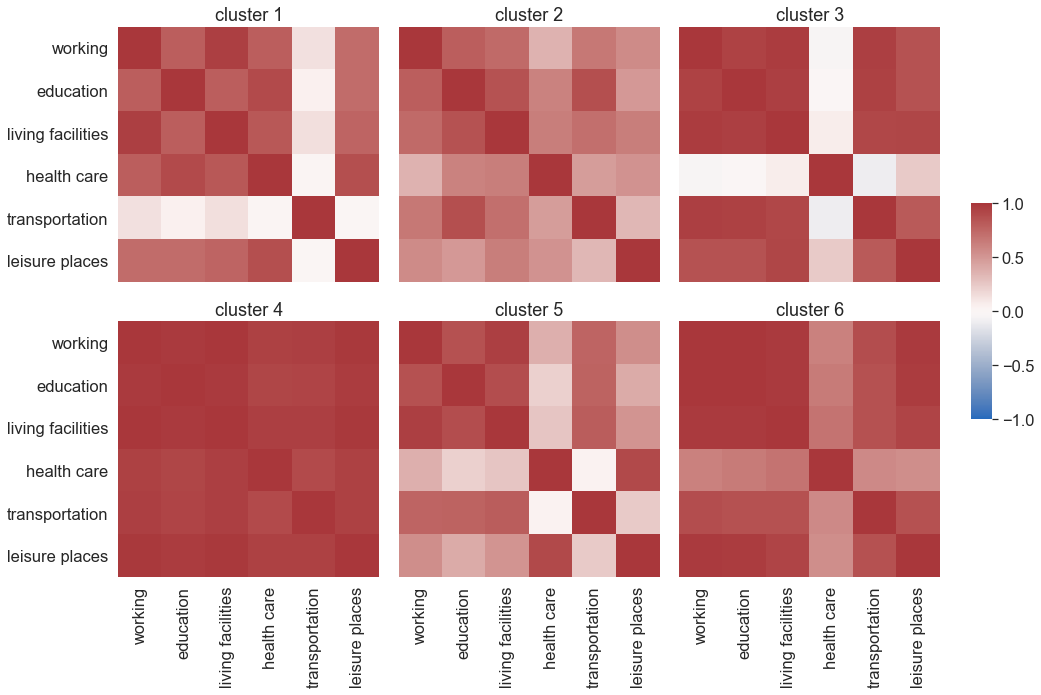

In [159]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,10))
cbar_ax = fig.add_axes([.91,.4,.02,.3])
for i in range(6):
    sns.heatmap(df_city_hi[df_city_hi['cluster']==i+1].iloc[:,0:6].corr(),cmap="vlag", xticklabels=True, yticklabels=True,cbar_ax=cbar_ax, vmin=-1, vmax=1,ax=axes[int(i/3),i%3]).set(title='cluster '+ str(i+1))
sns.set(font_scale=1.5)
fig.tight_layout(rect=[0, 0, .9, 1])
plt.show()

The correlation matrix are worked out by averaging the frequencies of venues over different categories. Thus, the resulting clusters by hierarchical clustering also present strongly positive correlations among the six categories, except for the individual categories that distinguishes different clusters. 

### <a name="rank"></a>4.3  Ranking of cities 

Find out the top and bottom five cities in each fields. 

In [166]:
top5_w=df_city2.nlargest(5, ['working'], keep='first')
top5_e=df_city2.nlargest(5, ['education'], keep='first')
top5_lf=df_city2.nlargest(5, ['living facilities'], keep='first')
top5_h=df_city2.nlargest(5, ['health care'], keep='first')
top5_t=df_city2.nlargest(5, ['transportation'], keep='first')
top5_lp=df_city2.nlargest(5, ['leisure places'], keep='first')

bottom5_w=df_city2.nsmallest(5, ['working'], keep='first')
bottom5_e=df_city2.nsmallest(5, ['education'], keep='first')
bottom5_lf=df_city2.nsmallest(5, ['living facilities'], keep='first')
bottom5_h=df_city2.nsmallest(5, ['health care'], keep='first')
bottom5_t=df_city2.nsmallest(5, ['transportation'], keep='first')
bottom5_lp=df_city2.nsmallest(5, ['leisure places'], keep='first')

rank_top=pd.DataFrame({'working':top5_w.index,'education':top5_e.index,\
                  'living facilities':top5_lf.index,'health care':top5_h.index,\
                  'transportation':top5_t.index,'leisure places':top5_lp.index},\
                  columns=['working','education','living facilities','health care','transportation','leisure places'])
rank_bottom=pd.DataFrame({'working':bottom5_w.index,'education':bottom5_e.index,\
                  'living facilities':bottom5_lf.index,'health care':bottom5_h.index,\
                  'transportation':bottom5_t.index,'leisure places':bottom5_lp.index},\
                  columns=['working','education','living facilities','health care','transportation','leisure places'])

In [167]:
rank_top

working   education living facilities health care transportation  \
0  Düsseldorf  Düsseldorf              Köln      Bochum           Köln   
1        Köln        Köln        Düsseldorf        Köln       Duisburg   
2       Essen      Bochum             Essen    Dortmund     Düsseldorf   
3    Dortmund    Duisburg          Dortmund       Hagen          Essen   
4        Bonn       Essen              Bonn  Oberhausen       Solingen   

  leisure places  
0     Düsseldorf  
1           Köln  
2          Hagen  
3          Essen  
4          Herne

The top five cities, e.g., Düsseldorf, Köln, Bochum, Essen, Duisburg, are recommended for travelling or living based on peasonal requirements. 

In [168]:
rank_bottom

working    education  living facilities      health care  \
0            Ahlen        Ahlen             Alfter           Aachen   
1            Alpen       Alfter              Alpen           Alfter   
2         Arnsberg        Alpen    Bad Lippspringe            Alpen   
3      Bad Driburg     Arnsberg           Bergheim       Bad Honnef   
4  Bad Lippspringe  Bad Driburg  Bergisch Gladbach  Bad Lippspringe   

  transportation  leisure places  
0          Ahlen           Ahlen  
1         Alfter          Alfter  
2          Alpen        Arnsberg  
3       Arnsberg      Bad Honnef  
4    Bad Driburg  Bad Sassendorf

The bottom five cities, e.g., Ahlen, Alpen, Aachen, Alfter, Arnsberg, are suggested to add in the state's city planning and to be improved in the corresponding fields.

## <a name="conclusion"></a>5 Conclusions 

With the location data from Foursquare company, we visualized the different cities on maps. To simplify the issue, we focused on the fields of working, education, living facilities, health care, transportation, leisure places in North Rhine-Westphalia (NRW), Germany. 

Using the frequency of categorized venues as a data matrix, we classified the cities in NRW by $k$-means clustering. The $k$-means clustering is better to classify cities and identify the dominating cities, e.g.,D\"usseldorf and K\"oln in most fields, Dortmund and Essen in the fields of working, living and relaxing, and Bochum and Duisburg in the fields of health care and transportation. Besides, we use the hierarchical clustering to classify cities based on their correlation matrix, where the cities with strongly positive correlations are grouped together. The correlation among cities with respect to each field provides a new perspective for city planning, which will be efficient due to the collective development for those positively correlated cities. 

By ranking the cities based on the frequency values of venues in each field, we can find out the cities that are suitable for travelling or living. Meanwhile, we identify the cities that is to be improved in the facilities of the corresponding fields. However, due to a lack of high quality in the dataset, the results of this project may contain some biases. 



## <a name="references"></a>6 References 

1. North Rhine-Westphalia https://en.wikipedia.org/wiki/North_Rhine-Westphalia
2. Location data from https://foursquare.com
3. Map data from https://www.openstreetmap.org
4. $k$-means clustering https://scikit-learn.org/stable/modules/clustering.html#k-means
5. Hierarchical clustering https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering


